### Cadê Covid - Modelagem

In [113]:
import pandas as pd

In [289]:
def load_casos(file):
    df =  pd.read_csv(file)
    df['date'] = pd.to_datetime(df.date)
    
    return df.sort_values('date')


def remove_cities(df):
    return (
        df[df.place_type == 'state'].drop('city', axis = 1)
                                    .rename(columns={'city_ibge_code' :'state_ibge_code'})
    )


def add_state_density(df, state_density_file, ano):
    state_density_df = (
        pd.read_csv(state_density_file)[['CODIGO_IBGE', ano]]
          .rename(columns={ano: 'population_density'})
    )
    df = df.join(state_density_df.set_index('CODIGO_IBGE'), how='left', on='state_ibge_code')
    
    return df[['state_ibge_code','state', 'population_density', 'date', 'epidemiological_week',
               'estimated_population_2019', 'is_last', 'is_repeated','last_available_confirmed',
               'last_available_confirmed_per_100k_inhabitants', 'last_available_date',
               'last_available_death_rate', 'last_available_deaths', 'new_confirmed','new_deaths', 
               'order_for_place', 'place_type']]


def add_new_confirmed_mm(df, window):
    new_confirmed_df = (
        df[['date','state_ibge_code','new_confirmed']].set_index('date')
          .groupby('state_ibge_code')
          .new_confirmed
          .rolling(window)
          .mean()
    )
    
    return df.join(new_confirmed_df, on=['state_ibge_code', 'date'], rsuffix='_mm')


def add_new_cofirmed_mm_is_decreasing(df):
    is_decreasing_df = (
        df[['date','state_ibge_code','new_confirmed_mm']].set_index('date')
          .groupby('state_ibge_code')
          .new_confirmed_mm
          .rolling(2)
          .apply(lambda x: x.iloc[0] > x.iloc[1])
          .replace({0 : False, 1: True})
    )
    
    return df.join(is_decreasing_df, on=['state_ibge_code', 'date'], rsuffix='_is_dec')

In [290]:
casos_csv = '../data_source/brasil_io_caso_full.csv'

In [240]:
state_density_csv = "../data_source/states_density.csv"
ano = '2010'
window = 14

In [294]:
casos_df = (
    load_casos(casos_csv).pipe(remove_cities)
                         .pipe(add_state_density, state_density_csv, ano)
                         .pipe(add_new_confirmed_mm, window)
                         .pipe(add_new_cofirmed_mm_is_decreasing)
                         .reset_index()
)

<AxesSubplot:xlabel='date'>

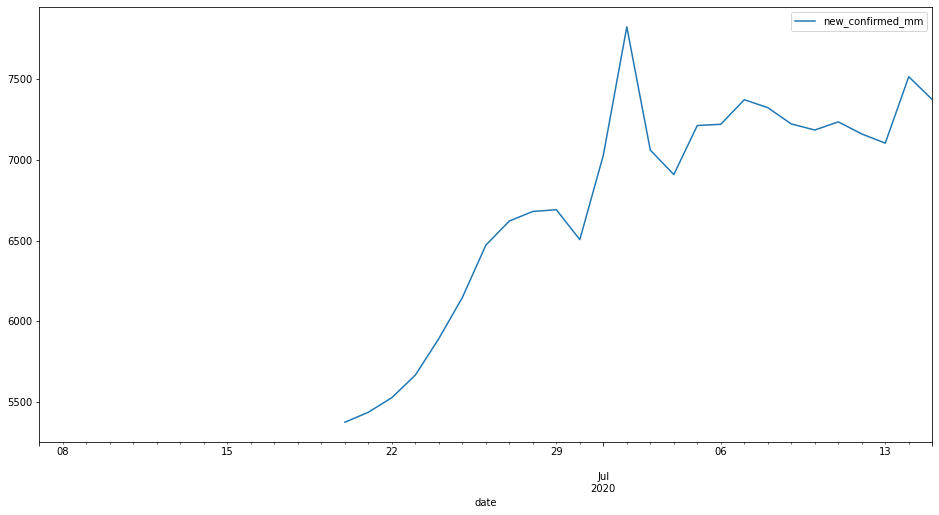

In [311]:
casos_df[casos_df.state=='SP'].plot(x='date', y='new_confirmed_mm', figsize=[16,8])